# Hate Speech Classification with a Long-Short Term Memory Model

The Long-Short Term Memory (LSTM) model is an improvement on the Recurrent Neural Network (RNN) architecture. A RNN processes each element of the input sequentially and updates its parameters using a variation of backpropagation known as backpropagation through time (BPTT). BPTT unrolls the time steps, applies backpropagation and rolls the recurrent structure back up. RNNs are unable to capture a consetual representation of long sequences of data as they have no long term memory. This makes them instable and inefficient as they commonly suffer with vanishing/exploding gradients, halting the learning process.

LSTMs work differently. Each LSTM module contains a cell state and a hidden state. The cell state allows a representation of the data to run through the model and undergo updates via linear instructions determined by internal gates. There is a forget gate; used to discard information, an input gate to add new information and an output gate which finalises the state of the module. By maintaining a consistent cell state, gradients flow easily through the network, mitigating the vanishing/exploding gradient problem in most cases. Compared to RNNs, LSTMs have significantly better stability and memory. 

## Imports

In [2]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torch import nn
from torchtext.data.utils import get_tokenizer
from collections import Counter
import torch.optim as optim
import torch.nn.utils.rnn as rnn_utils
import matplotlib.pyplot as plt
import numpy as np
import time
from torchtext.vocab import Vocab
import json
import seaborn as sns
import torchtext
from wordcloud import WordCloud
import re
import random

sns.set()

## Data PreProcessing

All datasets come with their own format. This cell is used to standardise them and strip them of unnecessary data, reducing them to `label` and `text` columns.

In [3]:
"""
Dataset: 
kaggle.com/datasets/kazanova/sentiment140
"""

df = pd.read_csv(
    'Data/Unprocessed/training.1600000.processed.noemoticon.csv', 
    encoding='latin', 
    header=None
    )
df.columns = ['label', 'id', 'date', 'query', 'user_id', 'text']
df = df.drop(columns=['id', 'date', 'query', 'user_id'])

df['label'].mask(df['label'] == 0, 1, inplace=True)
df['label'].mask(df['label'] == 2, 0, inplace=True)
df['label'].mask(df['label'] == 4, 0, inplace=True)

"""
Dataset: 
hasocfire.github.io/hasoc/2021/dataset.html
"""

df_2 = pd.read_csv(
    'Data/Unprocessed/hasoc_english_dataset.tsv', 
    delimiter='\t'
    )
df_2 = df_2.drop(columns=['text_id', 'task_1', 'task_3'])
df_2 = df_2.rename(columns={'task_2': 'label'})

df_2['label'].mask(df_2['label'] == 'HATE', 1, inplace=True)
df_2['label'].mask(df_2['label'] == 'OFFN', 1, inplace=True)
df_2['label'].mask(df_2['label'] == 'PRFN', 1, inplace=True)
df_2['label'].mask(df_2['label'] == 'NONE', 0, inplace=True)

"""
Dataset: 
figshare.com/articles/dataset/Labelled_Hate_Speech_Detection_Dataset_/19686954
"""

df_3 = pd.read_csv('Data/Unprocessed/HateSpeechDetection.csv')
df_3 = df_3.drop(columns=['Platform'])
df_3 = df_3.rename(columns={'Comment': 'text'})
df_3 = df_3.rename(columns={'Hateful': 'label'})

"""
Dataset: 
zenodo.org/record/3706866
"""

df_4 = pd.read_csv(
    'Data/Unprocessed/hatespeech_text_label_vote_RESTRICTED_100K.csv'
    )
df_4 = df_4.drop(columns=['Votes for the majority label'])
df_4 = df_4.rename(columns={'Tweet text': 'text'})
df_4 = df_4.rename(columns={'Label': 'label'})

df_4['label'].mask(df_4['label'] == 'normal', 0, inplace=True)
df_4['label'].mask(df_4['label'] == 'spam', 0, inplace=True)
df_4['label'].mask(df_4['label'] == 'abusive', 1, inplace=True)
df_4['label'].mask(df_4['label'] == 'hateful', 1, inplace=True)
df_4['text'] = df_4['text'].str.replace('RT', '')

"""
Dataset: 
kaggle.com/datasets/ashwiniyer176/toxic-tweets-dataset
"""

df_5 = pd.read_csv('Data/Unprocessed/FinalBalancedDataset.csv')
df_5.rename({"Unnamed: 0":"a"}, axis="columns", inplace=True)
df_5.drop(["a"], axis=1, inplace=True)
df_5 = df_5.rename(columns={'Toxicity': 'label'})
df_5 = df_5.rename(columns={'tweet': 'text'})
df_5['text'] = df_5['text'].str.replace('ð', '')

"""
Dataset: 
kaggle.com/datasets/cosmos98/twitter-and-reddit-sentimental-analysis-dataset
"""

df_6 = pd.read_csv('Data/Unprocessed/Reddit_Data.csv')
df_6 = df_6.rename(columns={'clean_comment': 'text'})
df_6 = df_6.rename(columns={'category': 'label'})
df_6.drop(df_6[df_6['label'] == 0].index, inplace=True)
df_6 = df_6[df_6['text'] != '']
df_6['label'].mask(df_6['label'] == 1, 0, inplace=True)
df_6['label'].mask(df_6['label'] == -1, 1, inplace=True)

"""
Concatenate datasets
"""

processed_data = pd.concat([df, df_2, df_3, df_4, df_5, df_6])

processed_data['text'] = processed_data['text'].str.replace('https', '')
processed_data['text'] = processed_data['text'].str.replace('t', '')
processed_data['text'] = processed_data['text'].str.replace('co', '')
processed_data['text'] = processed_data['text'].str.replace('amp', '')
processed_data['text'] = processed_data['text'].str.replace('quo', '')

# save all data
processed_data.to_csv('Data/processed_data.csv')
print(len(processed_data))
processed_data.head()

1789694


,label,text
0,1,"@swichfoo hp://wipic.m/2y1zl - Awww, ha's a bu..."
1,1,is upse ha he can' updae his Facebook by exing...
2,1,@Kenichan I dived many imes for he ball. Manag...
3,1,my whole body feels ichy and like is on fire
4,1,"@naionwideclass no, i's no behaving a all. i'm..."


## Word Clouds

(-0.5, 399.5, 299.5, -0.5)

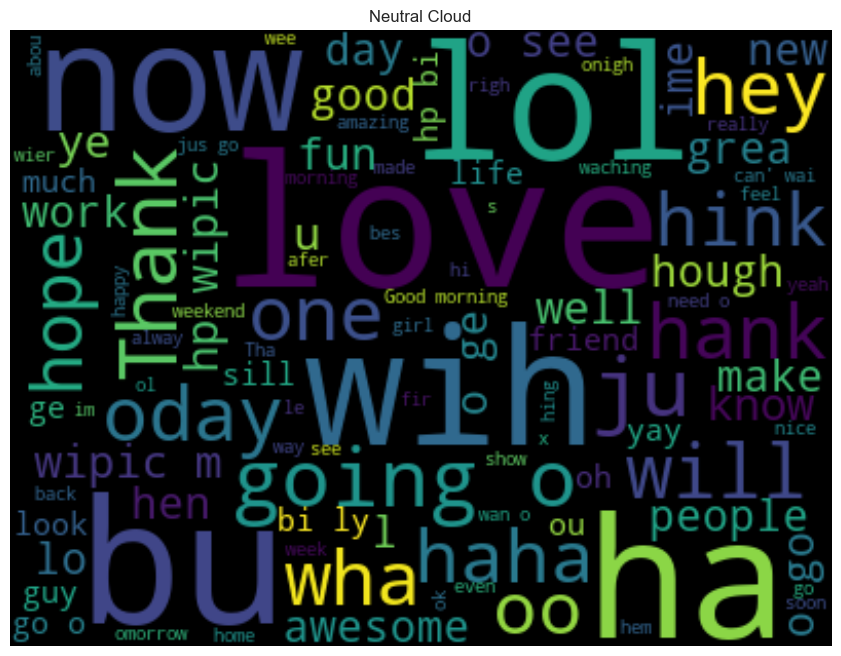

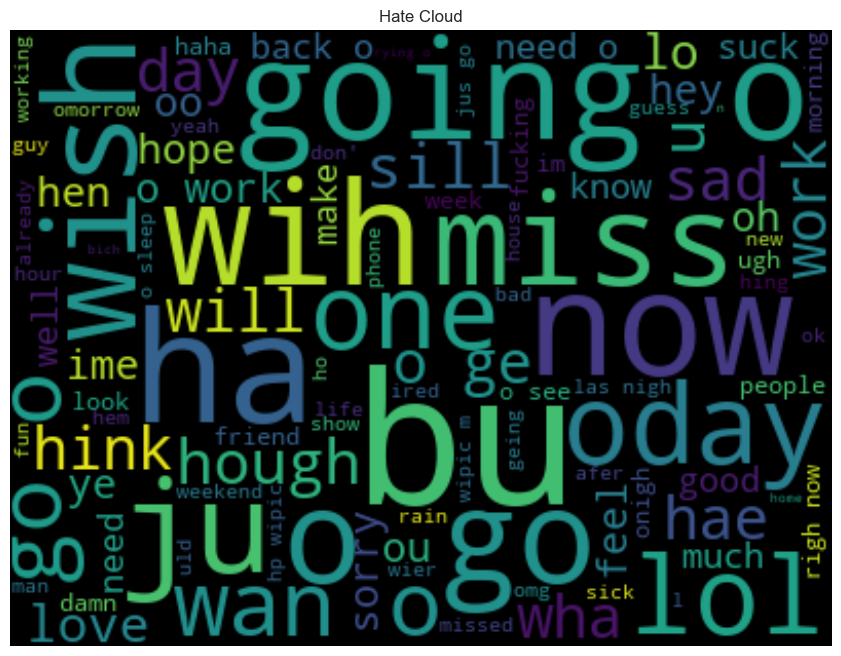

In [5]:
neutral_words = ' '.join([word for word in processed_data['text'][processed_data['label'] == 0]])

neutral_cloud = WordCloud(width=400, height=300, max_font_size=90, max_words=100).generate(neutral_words)
plt.figure(figsize=(12, 8))
plt.imshow(neutral_cloud, interpolation='bilinear', cmap='viridis')
plt.title('Neutral Cloud')
plt.axis('off')

hate_words = ' '.join([word for word in processed_data['text'][processed_data['label'] == 1]])

hate_cloud = WordCloud(width=400, height=300, max_font_size=90, max_words=100).generate(hate_words)
plt.figure(figsize=(12, 8))
plt.imshow(hate_cloud, interpolation='bilinear', cmap='viridis')
plt.title('Hate Cloud')
plt.axis('off')

## Create Datasets

Splitting the total data into training, validation and test sets.

As the length of the dataset is very large I am splitting it into 4 so the model can be trained periodically.

In [6]:
# split the data in half
first_half = processed_data.sample(frac=0.5)
second_half = processed_data.drop(first_half.index)

# halve one half
data_1 = first_half.sample(frac=0.5)
data_2 = first_half.drop(data_1.index)

# halve the second half
data_3 = second_half.sample(frac=0.5)
data_4 = second_half.drop(data_3.index)

# reset indexes
data_1.reset_index(drop=True, inplace=True)
data_2.reset_index(drop=True, inplace=True)
data_3.reset_index(drop=True, inplace=True)
data_4.reset_index(drop=True, inplace=True)

# save to disk
data_1.to_csv('Data/Split Datasets/data_1.csv')
data_2.to_csv('Data/Split Datasets/data_2.csv')
data_3.to_csv('Data/Split Datasets/data_3.csv')
data_4.to_csv('Data/Split Datasets/data_4.csv')

In [7]:
def train_val_test_split(data):
    """
    Used to split a dataset into training, validation and testing sets
    Uses 80% of the data to create a training set
    Uses 20% of the data to create a test set
    Uses 20% of the training data to create a validation set

    Args:
        data (DataFrame): Pandas DataFrame which needs splitting

    Returns:
        train_data, val_data, test_data 
            (DataFrame, DataFrame, DataFrame): training, validation and 
            test set
    """
    train_data_ = data.sample(frac=0.8)
    test_data = data.drop(train_data_.index)
    train_data = train_data_.sample(frac=0.8)
    val_data = train_data_.drop(train_data.index)
    return train_data, val_data, test_data

def dataset_details(dataset, data_name, set_name):
    """
    Displays the number of samples in each split

    Args:
        dataset (_type_): _description_
        data_name (_type_): _description_
        set_name (_type_): _description_
    """
    num_samples = len(dataset)
    num_label_0 = Counter(dataset['label'].tolist())[0]
    num_label_1 = Counter(dataset['label'].tolist())[1]
    split_percent = num_label_1 / num_samples * 100
    print('*' + '-' * 19 + '*')
    print(f'|      {data_name:11}  |')
    print(f'|      {set_name:11}  |')
    print('|' + '-' * 19 + '|')
    print(f'| Samples : {num_samples:7} |')
    print('*' + '-' * 19 + '*')
    print(f'| Neutral : {num_label_0:6}  |')
    print(f'| Hate    : {num_label_1:6}  |')
    print(f'| Split   : {split_percent:.2f}%  |')
    print('*' + '-' * 19 + '*')
    if set_name == 'Testing':
        print('\n\n')

In [8]:
"""
Create train/val/test sets from each data folder. 
Save them and display details.
"""

data_name = 'Data 1'
train, val, test = train_val_test_split(data_1)
dataset_details(train, data_name=data_name, set_name='Training')
dataset_details(val, data_name=data_name, set_name='Validation')
dataset_details(test, data_name=data_name, set_name='Testing')

train.to_csv('Data/Split Datasets/data_1/train.csv')
val.to_csv('Data/Split Datasets/data_1/val.csv')
test.to_csv('Data/Split Datasets/data_1/test.csv')

data_name = 'Data 2'
train, val, test = train_val_test_split(data_2)
dataset_details(train, data_name=data_name, set_name='Training')
dataset_details(val, data_name=data_name, set_name='Validation')
dataset_details(test, data_name=data_name, set_name='Testing')

train.to_csv('Data/Split Datasets/data_2/train.csv')
val.to_csv('Data/Split Datasets/data_2/val.csv')
test.to_csv('Data/Split Datasets/data_2/test.csv')

data_name = 'Data 3'
train, val, test = train_val_test_split(data_3)
dataset_details(train, data_name=data_name, set_name='Training')
dataset_details(val, data_name=data_name, set_name='Validation')
dataset_details(test, data_name=data_name, set_name='Testing')

train.to_csv('Data/Split Datasets/data_3/train.csv')
val.to_csv('Data/Split Datasets/data_3/val.csv')
test.to_csv('Data/Split Datasets/data_3/test.csv')

data_name = 'Data 4'
train, val, test = train_val_test_split(data_4)
dataset_details(train, data_name=data_name, set_name='Training')
dataset_details(val, data_name=data_name, set_name='Validation')
dataset_details(test, data_name=data_name, set_name='Testing')

train.to_csv('Data/Split Datasets/data_4/train.csv')
val.to_csv('Data/Split Datasets/data_4/val.csv')
test.to_csv('Data/Split Datasets/data_4/test.csv')

*-------------------*
|      Data 1       |
|      Training     |
|-------------------|
| Samples :  286351 |
*-------------------*
| Neutral : 147791  |
| Hate    : 138560  |
| Split   : 48.39%  |
*-------------------*
*-------------------*
|      Data 1       |
|      Validation   |
|-------------------|
| Samples :   71588 |
*-------------------*
| Neutral :  36780  |
| Hate    :  34808  |
| Split   : 48.62%  |
*-------------------*
*-------------------*
|      Data 1       |
|      Testing      |
|-------------------|
| Samples :   89485 |
*-------------------*
| Neutral :  46249  |
| Hate    :  43236  |
| Split   : 48.32%  |
*-------------------*



*-------------------*
|      Data 2       |
|      Training     |
|-------------------|
| Samples :  265522 |
*-------------------*
| Neutral : 138212  |
| Hate    : 127310  |
| Split   : 47.95%  |
*-------------------*
*-------------------*
|      Data 2       |
|      Validation   |
|-------------------|
| Samples :   66380 |
*------

## Collate Batches and Initialise DataLoaders

Collates `label`/`text` pairs into tuples, where the text is transformed into its GloVe embedding. Sequences are padded and tensors are moved to the GPU. 

Batches are padded so they are all the same length. 

These functions are called when DataLoaders are initialised to shuffle the data each epoch and process the batches using the pipeline described above.


In [9]:
def collate_batch(batch, embeddings):
    """
    Custom collate function to prepare batches for LSTM processing
    Assumes embedding dimension shape (50,)

    Args:
        batch (numpy.array): List of tuples containing label/text pairs
        embeddings (dict): Dictionary of word/vector pairs

    Returns:
        label_list, text_list, text_lengths 
        (torch.tensor, torch.tensor, torch.tensor): 
            tensors of labels, padded embeddings and text lengths.
            Tensors are moved to GPU/CPU device specified globally.
    """
    # lists to store labels and text embeddings
    label_list, text_list = [], []
    for (label, text) in batch:
        # convert the label to an integer and store it
        label_list.append(int(label))
        embedding = []
        for word in text.split():
            # get word embedding
            # if word doesn't exist return vector of 0's
            vector = embeddings.get(word, np.zeros((50,)))
            # convert embedding to torch tensor and store it
            embedding.append(torch.tensor(vector, dtype=torch.float32))
        # stack embeddings into matrix and store in text_list
        text_list.append(torch.stack(embedding))
    # convert labels to tensor
    label_list = torch.tensor(label_list, dtype=torch.int64)
    # pad all sequences to same length
    text_list = rnn_utils.pad_sequence(text_list, batch_first=True)
    # create tensor storing length of text sequences
    text_lengths = torch.tensor([len(t) for t in text_list], dtype=torch.int64)
    # return data after moving to specified device (GPU/CPU)
    return label_list.to(device), text_list.to(device), text_lengths.to(device)


def batch_padding(batch_size, embeddings):
    """
    Pads batches to specified size then processes using `collate_fn()`. 
    Pads by repeating the last element until batch_size is reached.

    Args:
        batch_size (int): The size of each batch.
        embeddings (dict): Dictionary of word embeddings.
    
    Returns:
        collate_fn (function): Function to pad a batch and 
            processes it `collage_batch()`
    """
    def collate_fn(batch):
        padded_batch = batch + [batch[-1]] * (batch_size - len(batch))
        return collate_batch(padded_batch, embeddings)
    return collate_fn

## Vocabulary and DataLoaders

GloVe (Global Vectors for Word Representation) embeddings are vector 
representations of words with semantically similar words being projected 
closer together.

Loads the GloVe embeddings file into a dictionary where the key is the word and 
the value is the vector.

Creates the DataLoaders for the training, validation and test sets for a given
dataset


In [10]:
def glove_embedding_dict():
    embedding_dict = {} 

    with open("Data/GloVe/glove.twitter.27B.50d.txt", 'r', encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], "float32")
            embedding_dict[word] = vector
    return embedding_dict



def init_dataloaders(folder, embedding_dict, batch_size):
    train = pd.read_csv(
        f'Data/Split Datasets/{folder}/train.csv'
        ).drop(columns=['Unnamed: 0'])
    val = pd.read_csv(
        f'Data/Split Datasets/{folder}/val.csv'
        ).drop(columns=['Unnamed: 0'])
    test = pd.read_csv(
        f'Data/Split Datasets/{folder}/test.csv'
        ).drop(columns=['Unnamed: 0'])

    train = train.to_numpy()
    val = val.to_numpy()
    test = test.to_numpy()

    train_loader = DataLoader(
        train, 
        batch_size=batch_size, 
        shuffle=True, 
        collate_fn=batch_padding(batch_size, embedding_dict)
        )
        
    val_loader = DataLoader(
        val, 
        batch_size=batch_size, 
        shuffle=True, 
        collate_fn=batch_padding(batch_size, embedding_dict)
        )

    test_loader = DataLoader(
        test, 
        batch_size=batch_size, 
        shuffle=True, 
        collate_fn=batch_padding(batch_size, embedding_dict)
        )

    return train_loader, val_loader, test_loader

## Training and Evaluation Functions

In [11]:
# Helper function for plotting training/validation loss over epochs

def plot_metrics(t_metric, v_metric, metric, num_epochs):
    """
    Displays accuracy and validation metrics plotted on line graphs.

    Args:
        t_metric (list): Accuracy/loss values during training.
        v_metric (list): Accuracy/loss values during validation.
        metric (str): Type of metric being plotted
        num_epochs (int): Number of epochs the model was trained.
    """
    plt.plot(t_metric, c='blue', label=f'Training')
    plt.plot(v_metric, c='red', label=f'Validation')
    plt.ylabel(f'{metric.title()}')
    plt.xlabel('Epoch')
    plt.title(f'{metric.title()} over {num_epochs} epochs')
    plt.legend()
    plt.show()

def train(dataloader, model, optimizer, scheduler, criterion, epoch, verbose=True):
    """
    Used to train a neural network.
    Sets the model to training mode and initialises variables to keep 
    track of metrics during training.
    Iterates through label/text pairs from each dataset making label
    predictions. 
    Calculates loss and backpropagates parameter updates
    through the network to ideally reduce loss over epochs.

    Args:
        dataloader (DataLoader): DataLoader containing training
            data.
        model (nn.Module): The LSTM model being trained.
        optimizer (torch.optim.sgd): Backpropagation method.
        criterion (torch.nn.modules.loss): Loss function.
        epoch (int): The current epoch.
        verbose (Boolean): Display metrics (default=True).

    Returns:
        epoch_loss, epoch_accuracy, epoch_count 
            (float, float, int): loss, accuracy and number of 
            predictions made in one epoch.
    """
    model.train()
    # number of accurate predictions in batch
    batch_accuracy = 0
    # value of loss for each prediction in batch
    batch_loss = 0
    # number of predictions made in batch
    batch_count = 0
    # number of accurate predictions in epoch
    epoch_accuracy = 0
    # value of loss over eoch
    epoch_loss = 0
    # number of predictions made in epoch
    epoch_count = 0
    # displays training metrics every quarter of a batch
    intervals = (len(dataloader) / 4).__round__()
    # loss value for final batch
    last_loss = 0
    for idx, (label, text, text_lengths) in enumerate(dataloader):
        # make prediction
        prediction = model(text, text_lengths)
        label = label.unsqueeze(1)
        # compare prediction to label to calculate loss
        loss = criterion(prediction, label.float())
        batch_loss = loss.item()
        epoch_loss += batch_loss
        # update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # store metrics
        batch_accuracy += ((prediction > 0.5) == label).sum().item()
        batch_count += label.size(0)
        epoch_accuracy += batch_accuracy
        epoch_count += batch_count
        if verbose and idx % intervals == 0 and idx > 0:
            epoch_metrics = (
                f'| Epoch {epoch + 1} |' 
                f'{idx:5} / {len(dataloader):5} batches |' 
                f'{(batch_accuracy/batch_count)*100:.10f}% accurate |'
                )
            print(epoch_metrics)
            batch_accuracy = 0
            batch_count = 0
    scheduler.step()
    return epoch_loss, epoch_accuracy, epoch_count

def evaluate(dataloader, model, criterion):
    """
    Used to evaluate model training.
    Works similarly to the training method, allowing the model
    to make predictions on labelled data, however no parameters are
    updated.

    Args:
        dataloader (DataLoader): DataLoader containing either validation
            or testing data.
        model (nn.Module): The LSTM model being trained.
        criterion (torch.nn.modules.loss): Loss function.

    Returns:
        batch_loss, batch_accuracy, batch_count 
            (float, float, int): loss, accuracy and number of 
            predictions made over the validation set.
    """
    model.eval()
    total_accuracy = 0
    total_count = 0
    total_loss = 0
    with torch.no_grad():
        for idx, (label, text, text_length) in enumerate(dataloader):
            prediction = model(text, text_length)
            label = label.unsqueeze(1)
            loss = criterion(prediction, label.float())
            total_accuracy += ((prediction > 0.5) == label).sum().item()
            total_count += label.size(0)
            total_loss += loss.item()
    return total_loss, total_accuracy, total_count

def model_env(training, 
              validation, 
              testing, 
              model, 
              optimizer,
              scheduler, 
              criterion, 
              epochs, 
              verbose=True):
    """
    Wraps the training and evaluation functions in one method.
    At the end of each epoch, the model asseses the validation set.

    Args:
        training (DataLoader): DataLoader with training data.
        validation (DataLoader): DataLoader with validation data.
        testing (DataLoader): DataLoader with testing data.
        model (nn.Module): The LSTM model being trained.
        optimizer (torch.optim.sgd): Backpropagation method.
        criterion (torch.nn.modules.loss): Loss function.
        epochs (int): Number of epochs the model is trained for.
        verbose (Boolean): Display metrics (default=True).

    Returns:
        train_accuracy, train_loss, val_accuracy, val_loss 
            (list, list, list, list): Metrics saved during training.
    """
    # save loss and accuracy values during training and evaluation
    train_accuracy = []
    train_loss = []
    val_accuracy = []
    val_loss = []
    # save start time
    start_time = time.time()
    for epoch in range(epochs):
        epoch_start = time.time()
        print('-' * 59)
        print(f'|\t\t          Epoch {epoch + 1}           \t\t  |')
        print('-' * 59)
        loss, acc, count = train(training, 
                                 model, 
                                 optimizer,
                                 scheduler, 
                                 criterion, 
                                 epoch, 
                                 verbose)  
        train_loss.append(loss)
        train_accuracy.append(acc)
        loss, acc, count = evaluate(validation, model, criterion)
        val_loss.append(loss)
        val_accuracy.append(acc)
        val_ratio = (acc/count)*100
        print('-' * 59)
        epoch_metrics = (
            f'| End of epoch {epoch + 1} |'
            f'Time: {time.time() - epoch_start:.2f}s |'
            f'Acc: {val_ratio:.14f}%  |'
        )
        print(epoch_metrics)
        print('-' * 59)
        print()
    loss, acc, count = evaluate(testing, model, criterion)
    test_ratio = (acc/count)*100
    total_time = (time.time() - start_time).__round__()/60
    max_acc = max(val_accuracy)
    print('*' + '-' * 57 + '*')
    test_metrics = (
        f'*\t\t\tTesting Epoch\t\t\t  *\n'
        f'*' + '-' * 57 + '*\n'
        f'* \t\t      Time: {total_time:.2f} minutes\t\t  *\n'
        f'*\t\t    Acc: {test_ratio:.14f}%     \t  *'
    )
    print(test_metrics)
    print('*' + '-' * 57 + '*')
    return train_accuracy, train_loss, val_accuracy, val_loss

## Defining the Model

In [32]:
class LSTM_Model(nn.Module):
    def __init__(self, vector_dim, num_hidden_nodes, num_layers):
        super(LSTM_Model, self).__init__()

        self.lstm1 = nn.LSTM(
            vector_dim, 
            num_hidden_nodes*25, 
            num_layers=3, 
            bidirectional=True, 
            dropout=0.3, 
            batch_first=True
        )

        self.lstm2 = nn.LSTM(
            num_hidden_nodes*50, 
            num_hidden_nodes*25, 
            num_layers=3, 
            bidirectional=True, 
            dropout=0.3, 
            batch_first=True
        )

        self.fc1 = nn.Linear(num_hidden_nodes*50, 120)
        self.fc2 = nn.Linear(120, 40)
        self.fc3 = nn.Linear(40, 1)

        self.lstm_bn = nn.BatchNorm1d(num_hidden_nodes*50)
        
        self.fc1_bn = nn.BatchNorm1d(120)
        self.fc2_bn = nn.BatchNorm1d(40)

        self.relu = nn.ReLU()
        self.fc_dropout = nn.Dropout(0.2)

    def forward(self, text, text_lengths):
        x, _ = self.lstm1(text)
        x, _ = self.lstm2(x)
        x = x[torch.arange(x.shape[0]), text_lengths - 1, :]
        x = self.fc1_bn(self.fc_dropout(self.relu(self.fc1(x))))
        x = self.fc2_bn(self.fc_dropout(self.relu(self.fc2(x))))
        x = self.fc3(x)
        return x

## Define Hyperparameters and Train

In [39]:
"""
Train and evaluate model on GPU if possible ("mps" used for M1 Mac)
"""
if torch.backends.mps.is_available():
    if torch.backends.mps.is_built():
        print("Using MPS\n")
        device = torch.device("mps")
else:
    print("Using CPU\n")
    device = torch.device("cpu")

dimensions = 50
hidden_nodes = 4
hidden_layers = 2

lstm_ = LSTM_Model(
    vector_dim=dimensions, 
    num_hidden_nodes=hidden_nodes, 
    num_layers=hidden_layers
    ).to(device)

# Using PyTorch's compile method
lstm = torch.compile(lstm_, backend='inductor')

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(lstm.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)

params = sum(p.numel() for p in lstm.parameters())
print(f"LSTM has {params} parameters.")

Using MPS

LSTM has 1359321 parameters.


In [40]:
"""
This cell is used for testing with a small data folder
"""
glove_embeddings = glove_embedding_dict()
epochs = 1

train_loader, val_loader, test_loader = init_dataloaders(
    folder='data_1',
    embedding_dict=glove_embeddings,
    batch_size=64
    )

t_acc, t_loss, v_acc, v_loss = model_env(
    train_loader, 
    val_loader, 
    test_loader, 
    lstm, 
    optimizer,
    scheduler, 
    criterion, 
    epochs, 
    verbose=True
    )

-----------------------------------------------------------
|		          Epoch 1           		  |
-----------------------------------------------------------
| Epoch 1 |   35 /   140 batches |51.9097222222% accurate |
| Epoch 1 |   70 /   140 batches |51.5178571429% accurate |
| Epoch 1 |  105 /   140 batches |49.3303571429% accurate |
-----------------------------------------------------------
| End of epoch 1 |Time: 157.92s |Acc: 52.27678571428571%  |
-----------------------------------------------------------

*---------------------------------------------------------*
*			Testing Epoch			  *
*---------------------------------------------------------*
* 		      Time: 2.83 minutes		  *
*		    Acc: 50.24857954545454%     	  *
*---------------------------------------------------------*


## Save the Model

This cell saves the current state of the model, as well as the optimizer dictionary. 
This enables the model to be trained in parts.

In [41]:
torch.save({
    'model_state_dict': lstm.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, 'checkpoint.pth')

## Load the Model

Load the model to resume training. 
Ensure the data folder is correct when creating new DataLoaders.

In [ ]:
if torch.backends.mps.is_available():
    if torch.backends.mps.is_built():
        print("Using MPS\n")
        device = torch.device("mps")
else:
    print('Model cannot train without MPS device\n')

dimensions = 50
hidden_nodes = 4
hidden_layers = 2

lstm_ = LSTM_Model(
    vector_dim=dimensions, 
    num_hidden_nodes=hidden_nodes, 
    num_layers=hidden_layers
    ).to(device)

# Using PyTorch's compile method
lstm = torch.compile(lstm_, backend='inductor')

optimizer = optim.Adam(lstm.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)
checkpoint = torch.load('checkpoint.pth')
lstm.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

glove_embeddings = glove_embedding_dict()

"""
Model has currently been trained on:
☑ data_1
☐ data_2
☐ data_3
☐ data_4
"""
data_folder = 'data_2'

train_loader, val_loader, test_loader = init_dataloaders(
    folder=data_folder, 
    embedding_dict=glove_embeddings,
    batch_size=64
    )

epochs = 1

t_acc, t_loss, v_acc, v_loss = model_env(
    train_loader, 
    val_loader, 
    test_loader, 
    lstm, 
    optimizer,
    scheduler, 
    criterion, 
    epochs, 
    verbose=True
    )

plot_metrics(t_acc, v_acc, 'Accuracy', epochs)
plot_metrics(t_loss, v_loss, 'Loss', epochs)

print(t_acc, v_acc, t_loss, v_loss)